# Init

In [ ]:
import os

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find("project")
# slice the path from the index of 'project' to the end
project_path = path[: index_project + 7]
# set the working directory
os.chdir(project_path + "/src")
print(f"Project path set to: {os.getcwd()}")

Project path set to: c:\Github\new-peak-project\src


In [2]:
from dotenv import dotenv_values
config = dotenv_values(".env")
print(config["DATA_PATH"])

I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\new-peak-project\experiments


In [3]:
new_path = config["NEW_DATA_PATH"]
print(f'New data path set to: {new_path}')

New data path set to: I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\data-and-mechanism-project


# Config

In [4]:
from models.utils.config_manager import initialise_config

initialise_config(folder_name="machine-learning", verbose=1)


Folder I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\data-and-mechanism-project\machine-learning already exists. No changes made.


In [5]:
# or load existing config
from models.utils.config_manager import load_configs, print_config

loaded_config = load_configs(folder_name="machine-learning", config_suffix="E3R_distort")
print_config(loaded_config)

notebook: 
  version: E3R_distort
  name: machine-learning
  compatible_notebooks: ['machine-learning-1']
  desc: The E3R system using almost no param range but with distortion factor 

exp: 
  spec: 
    n_layers: 2
    n_cascades: 3
    n_regs: 3
    gen_seed: 42
    drug: 
      name: D
      start: 500
      dose: 500
      regulations: []
      target_all: True
  parameter_generation: 
    ic_range: [200, 1000]
    param_range: [0.5, 1.5]
    param_mul_range: [0.99, 1.01]
  feature_generation: 
    include_parameters: False
    excluded_layers: ['O']
  simulation: 
    start: 0
    stop: 1000
    step: 100
  dynamic_data: 
    exclude_activated_form: False
    excluded_layers: []
    distortion: True
    distortion_factor: 2
  machine_learning: 
    ml_seed: 42
    outcome_var: Oa
    n_samples: 1000
    n_reps: 10


# Run

In [6]:
from models.Specs.ModelSpec3 import ModelSpec3

notebook_config = loaded_config["notebook"]
exp_config = loaded_config["exp"]
spec_config = exp_config['spec']
n_layers = spec_config['n_layers']
new_spec = ModelSpec3(num_intermediate_layers=n_layers)


In [7]:
import logging
from models.Specs.Drug import Drug
logging.basicConfig(level=logging.INFO)


drug_config = spec_config['drug']
drug_name = drug_config['name']
drug_start = drug_config['start']
drug_dose = drug_config['dose']
drug_regulations = drug_config['regulations']

n_cascades = spec_config["n_cascades"]
n_regs = spec_config["n_regs"]
seed = spec_config["gen_seed"]

new_drug = Drug(name=drug_name, start_time=drug_start, default_value=drug_dose)

# check if target_all exists in drug_config, if not set to False
drug_target_all = drug_config.get('target_all', False)

if drug_target_all:
    # If the drug targets all receptors, we don't need to add specific regulations
    for n in range(n_cascades):
        target = f'R{n+1}' # assuming receptors are named R1, R2, ..., Rn
        new_drug.add_regulation(target, 'down') # assuming the type is 'down' for all
else: 
    for regs in drug_regulations:
        target, type = regs[0], regs[1]
        new_drug.add_regulation(target, type)

new_spec.generate_specifications(n_cascades, n_regs, seed)
new_spec.add_drug(new_drug)

In [8]:
from numpy.random import SeedSequence

param_gen_config = exp_config['parameter_generation']
specie_range = param_gen_config['ic_range']
param_range = param_gen_config['param_range']
param_mul_range = param_gen_config['param_mul_range']
n_samples = exp_config['machine_learning']['n_samples']

# base build 
builder_base = new_spec.generate_network('base', specie_range, param_range, param_mul_range, seed)
params_base = builder_base.get_parameters()
states_base = builder_base.get_state_variables()

ss = SeedSequence(seed)
build_seeds = []
for i in range(n_samples):
    child_ss = ss.spawn(1)[0]
    build_seeds.append(child_ss.generate_state(1)[0])

parameter_sets = []
all_builds = []
for seed in build_seeds:
    builder = new_spec.generate_network(str(seed), specie_range, param_range, param_mul_range, seed)
    parameter_sets.append(builder.get_parameters())
    all_builds.append(builder)

INFO:models.Specs.ModelSpec3:Generated model base with 20 reactions.
INFO:models.Specs.ModelSpec3:Model States: 20
INFO:models.Specs.ModelSpec3:Model Parameters: 55
INFO:models.Specs.ModelSpec3:Model Reactions: 20
INFO:models.Specs.ModelSpec3:Generated model 2684470948 with 20 reactions.
INFO:models.Specs.ModelSpec3:Model States: 20
INFO:models.Specs.ModelSpec3:Model Parameters: 55
INFO:models.Specs.ModelSpec3:Model Reactions: 20
INFO:models.Specs.ModelSpec3:Generated model 4091952314 with 20 reactions.
INFO:models.Specs.ModelSpec3:Model States: 20
INFO:models.Specs.ModelSpec3:Model Parameters: 55
INFO:models.Specs.ModelSpec3:Model Reactions: 20
INFO:models.Specs.ModelSpec3:Generated model 233227757 with 20 reactions.
INFO:models.Specs.ModelSpec3:Model States: 20
INFO:models.Specs.ModelSpec3:Model Parameters: 55
INFO:models.Specs.ModelSpec3:Model Reactions: 20
INFO:models.Specs.ModelSpec3:Generated model 3276785861 with 20 reactions.
INFO:models.Specs.ModelSpec3:Model States: 20
INFO:m

In [9]:
from models.Solver.RoadrunnerSolver import RoadrunnerSolver

solver = RoadrunnerSolver()
solver.compile(builder_base.get_sbml_model())


INFO:numexpr.utils:NumExpr defaulting to 16 threads.


In [10]:
from models.SyntheticGen import generate_feature_data_v3, generate_target_data_diff_build
from models.utils.config_manager import save_data

sim_config = exp_config["simulation"]
sim_start = sim_config["start"]
sim_stop = sim_config["stop"]
sim_step = sim_config["step"]

feature_config = exp_config["feature_generation"]
excluded_layers = feature_config["excluded_layers"]

initial_values = builder.get_state_variables()
initial_values = {k: v for k, v in initial_values.items() if not k.endswith('a')} # should not perturb activated forms

if excluded_layers:
    for layer in excluded_layers:
        initial_values = {k: v for k, v in initial_values.items() if not k.startswith(f'{layer}')}

feature_data = generate_feature_data_v3(new_spec, initial_values, 'lhs', {'min': 200, 'max': 1000}, 500, seed)

sim_params = {
    'start': sim_start,
    'end': sim_stop,
    'points': sim_step
}

target_data, timecourse_data = generate_target_data_diff_build(new_spec, solver, feature_data, parameter_sets, sim_params, 
                                                               outcome_var='Oa', verbose=True)

save_data(notebook_config, target_data, 'target_data', verbose=1)
save_data(notebook_config, feature_data, 'feature_data', verbose=1)

Simulating perturbations: 100%|██████████| 500/500 [00:01<00:00, 347.21it/s]


In [11]:
feature_data

,R1,R2,R3,I1_1,I1_2,I1_3,I2_1,I2_2,I2_3
0,857.964338,594.905854,925.005318,829.347356,746.454930,718.483880,985.079961,890.674221,745.835347
1,861.022304,561.822337,499.073083,225.987949,613.644725,987.362243,554.299416,516.336852,351.242637
2,506.555831,272.718801,644.440575,986.311147,274.796746,568.134353,392.860470,835.022438,584.020662
3,480.209138,982.449787,388.585739,577.716527,479.987404,928.516373,960.151926,648.649268,574.763018
4,263.446910,937.302663,826.212903,458.213786,777.270486,590.629116,213.333574,893.342107,847.325013
...,...,...,...,...,...,...,...,...,...
495,741.220334,365.354028,799.549060,311.819487,624.498829,266.039010,423.402833,558.952101,328.475691
496,819.722732,208.140664,214.809818,516.943683,984.367700,933.707703,370.740407,233.029520,670.534812
497,835.181730,893.562375,878.435505,721.325082,998.488099,844.487855,978.745466,902.341498,611.642259
498,630.472801,873.074776,363.069358,395.874714,416.038031,965.754532,231.349330,888.724486,443.560713


In [12]:
# distortion 
from numpy.random import default_rng
from models.SyntheticGen import generate_model_timecourse_data_diff_build_v3

dynamic_data_config = exp_config['dynamic_data']
distortion = dynamic_data_config['distortion']


modified_parameter_sets = []
if distortion:
    print("Applying distortion to parameters...")
    distortion_factor = dynamic_data_config['distortion_factor']
    distort_range = (1 / distortion_factor, distortion_factor)

    rng = default_rng(seed)
    modified_parameter_sets = []
    for params in parameter_sets:
        new_params = {}
        for key, value in params.items():
            new_params[key] = (
                value * rng.uniform(distort_range[0], distort_range[1])
            )  # distortion range, expectation is that the larger the worse the model performance
        modified_parameter_sets.append(new_params)
else: 
    modified_parameter_sets = parameter_sets

# generate the timecourse data for the new model
distorted_timecourse = generate_model_timecourse_data_diff_build_v3(
    states_base,
    solver,
    feature_data,
    modified_parameter_sets,
    sim_params,
    capture_species="all",
    n_cores=1,
    verbose=True,
)


Applying distortion to parameters...


Simulating perturbations: 100%|██████████| 500/500 [00:01<00:00, 302.27it/s]


In [13]:
from models.utils.dynamic_calculations import dynamic_features_method, last_time_point_method

excluded_layers = dynamic_data_config["excluded_layers"]
exclude_active_form = dynamic_data_config["exclude_activated_form"]
initial_values = builder.get_state_variables()
if exclude_active_form:
    initial_values = {k: v for k, v in initial_values.items() if not k.endswith('a')} # should not perturb activated forms
if excluded_layers:
    for layer in excluded_layers:
        initial_values = {k: v for k, v in initial_values.items() if not k.startswith(f'{layer}')}

last_time_data = last_time_point_method(distorted_timecourse, initial_values.keys())
dynamic_data = dynamic_features_method(distorted_timecourse, initial_values.keys(), n_cores=4)

save_data(notebook_config, last_time_data, 'last_time_data', verbose=1)
save_data(notebook_config, dynamic_data, 'dynamic_data', verbose=1)

In [14]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

combined_lp_data = pd.concat([feature_data, last_time_data], axis=1)
combined_dyn_data = pd.concat([feature_data, dynamic_data], axis=1)
feature_data_list = [feature_data, last_time_data, dynamic_data, combined_lp_data, combined_dyn_data]
feature_data_names = ['feature_data', 'last_time_data', 'dynamic_data', 'combined_lp_data', 'combined_dyn_data']

ml_seed = exp_config['machine_learning']['ml_seed']
outcome_var = exp_config['machine_learning']['outcome_var']
n_reps = exp_config['machine_learning']['n_reps']

def evaluate_model(model, model_name, feature_data, feature_data_name, target_data, test_size=0.2, random_state=4):
    X_train, X_test, y_train, y_test = train_test_split(feature_data, target_data, test_size=test_size, random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # return a dictionary of the model performance
    return {'Model': model_name, 
            'Feature Data': feature_data_name,
            'Mean Squared Error': mean_squared_error(y_test, y_pred),
            'R2 Score': r2_score(y_test, y_pred),
            'Pearson Correlation': pearsonr(y_test, y_pred)[0],
            'Pearson P-Value': pearsonr(y_test, y_pred)[1]
            }
# create a linear regression model
lm = LinearRegression()
# create a random forest model
rf = RandomForestRegressor(n_estimators=100, random_state=ml_seed)
# create a gradient boosting model
gb = GradientBoostingRegressor(n_estimators=100, random_state=ml_seed)
# create a support vector machine model
svr = SVR(max_iter=10000)
scaled_svr = Pipeline([('scaler', StandardScaler()), ('svr', svr)])
# create a neural network model (simple)
nn = MLPRegressor(hidden_layer_sizes=(20,), max_iter=10000, random_state=ml_seed)
scaled_nn = Pipeline([('scaler', StandardScaler()), ('nn', nn)])

all_models = [lm, rf, gb, scaled_svr, scaled_nn]
all_models_desc = ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'Support Vector Machine', 'Neural Network']
zipped_model_data = list(zip(all_models, all_models_desc))
all_features = feature_data_list
all_features_desc = feature_data_names
zipped_feature_data = list(zip(all_features, all_features_desc))

# random states are rand ints between 0 and 10000, for n values 
np.random.seed(ml_seed)
n_random = n_reps
all_random_states = np.random.randint(0, 10000, n_random)

parallelise = True 
# tqdm is a progress bar library, use it to show the progress of the model evaluation
metric_data = []
if not parallelise:          
    for (feature_data, feature_data_name) in tqdm(zipped_feature_data):
        # print('Feature Data:', feature_data_name)
        # print('Feature Data Shape:', feature_data.shape)
        for (model, model_name) in zipped_model_data:
            # print('Model:', model_name)
            for rand in all_random_states:
                metrics = evaluate_model(model, model_name, feature_data, feature_data_name, target_data[outcome_var], random_state=rand)
                metric_data.append(metrics)
                
else:        
    # parallelise the model evaluation process using joblib
    from joblib import Parallel, delayed

    metric_data = Parallel(n_jobs=-1)(delayed(evaluate_model)(model, model_name, feature_data, feature_data_name, target_data[outcome_var], random_state=rand) 
                                    for (feature_data, feature_data_name) in zipped_feature_data
                                    for (model, model_name) in zipped_model_data
                                    for rand in all_random_states)

# make a dataframe of the metric data
metric_df = pd.DataFrame(metric_data)
metric_df

save_data(notebook_config, metric_df, 'metric_data', verbose=1)



Figure saved at I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\data-and-mechanism-project\machine-learning\figures\E3R_distort_model_performance_comparison_all.png


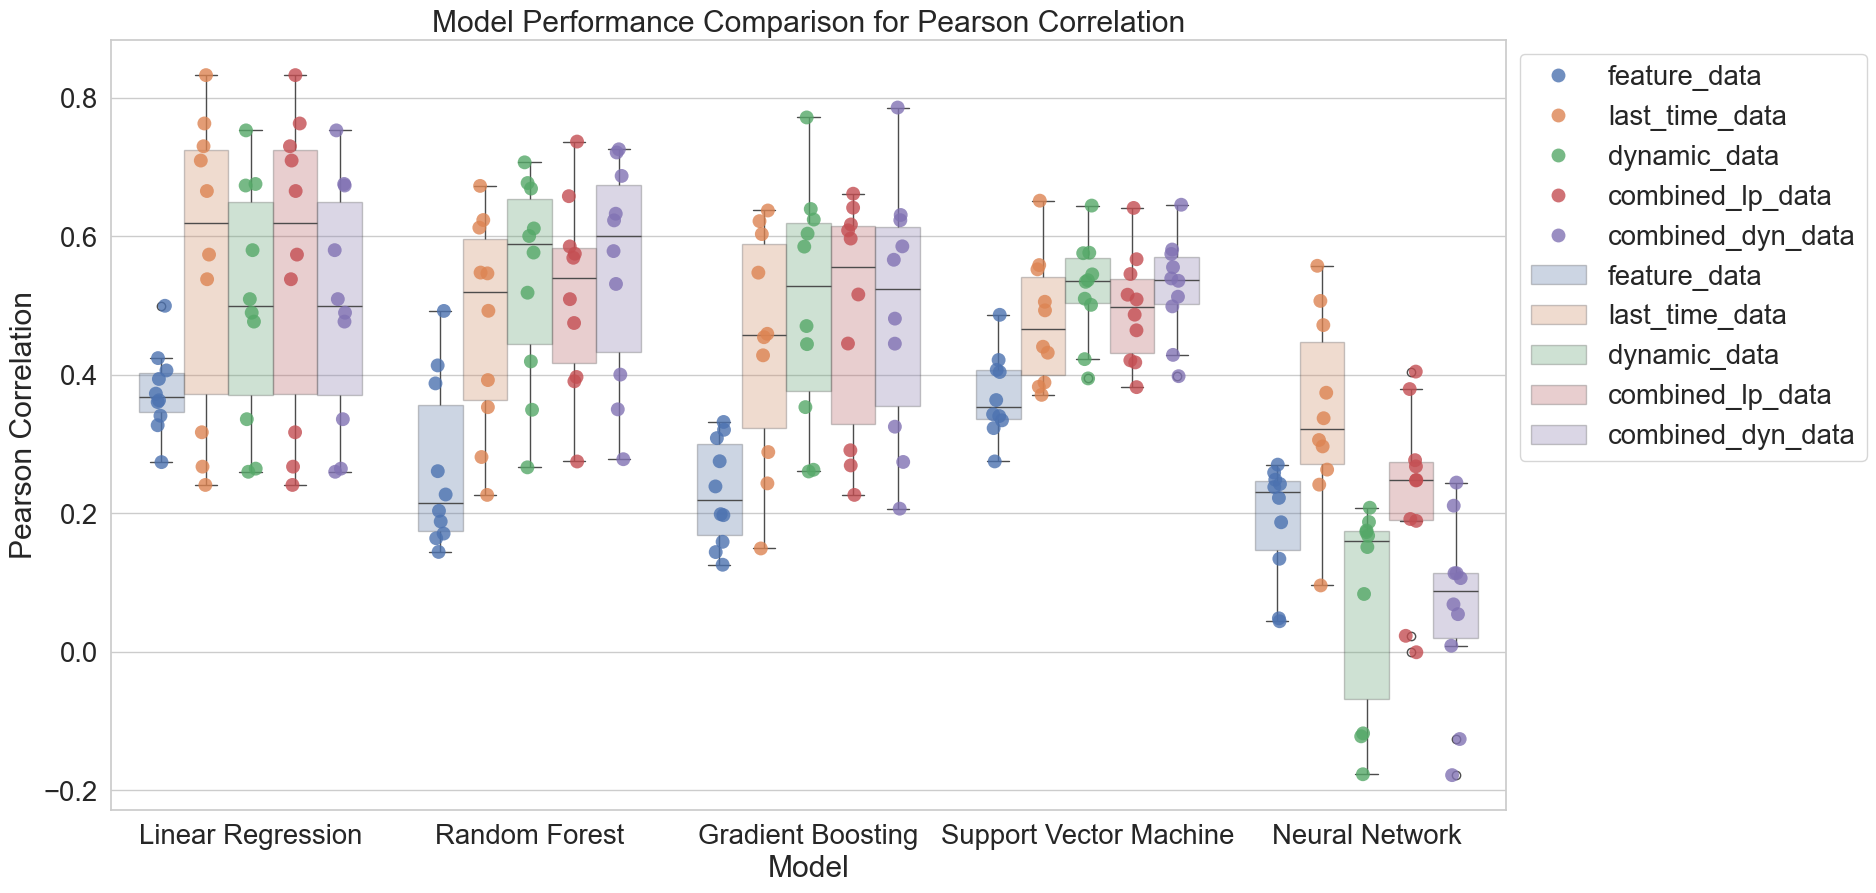

In [15]:
# create box plots for each model type and feature data type, plot for pearson correlation
import matplotlib.pyplot as plt
import seaborn as sns
from models.utils.config_manager import save_figure

sns.set(rc={'figure.figsize':(18,10)})
# make the font size bigger for labels and title, and axes labels 
sns.set(font_scale=1.8)
sns.set_style("whitegrid")
sns.stripplot(data=metric_df, x='Model', y='Pearson Correlation', hue='Feature Data', dodge=True, jitter=True, size=10, alpha=0.8)

# display the mean value for each model and feature data type
mean_vals = metric_df.groupby(['Model', 'Feature Data']).mean().reset_index()
    

# make a transparent box plot, without using the alpha parameter
sns.boxplot(data=metric_df, x='Model', y='Pearson Correlation', hue='Feature Data')
for patch in plt.gca().patches:
    patch.set_alpha(0.3)

plt.title('Model Performance Comparison for Pearson Correlation')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

save_figure(notebook_config, plt.gcf(), 'model_performance_comparison_all', verbose=1)
plt.show()

Group-wise Pearson Correlation (mean ± std):

Expression data          : 0.286 ± 0.110
Dynamic feature data     : 0.428 ± 0.229
Expression + dynamic data: 0.427 ± 0.235
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Expression data vs. Dynamic feature data: t-test paired samples, P_val:1.816e-05 t=-4.749e+00
Dynamic feature data vs. Expression + dynamic data: t-test paired samples, P_val:9.227e-01 t=9.751e-02
Expression data vs. Expression + dynamic data: t-test paired samples, P_val:2.396e-05 t=-4.667e+00
Figure saved at I:\My Drive\DAWSON PHD PROJECT\Biomarker Data Repository\data\data-and-mechanism-project\machine-learning\figures\E3R_distort_model_performance_comparison_style_2.png


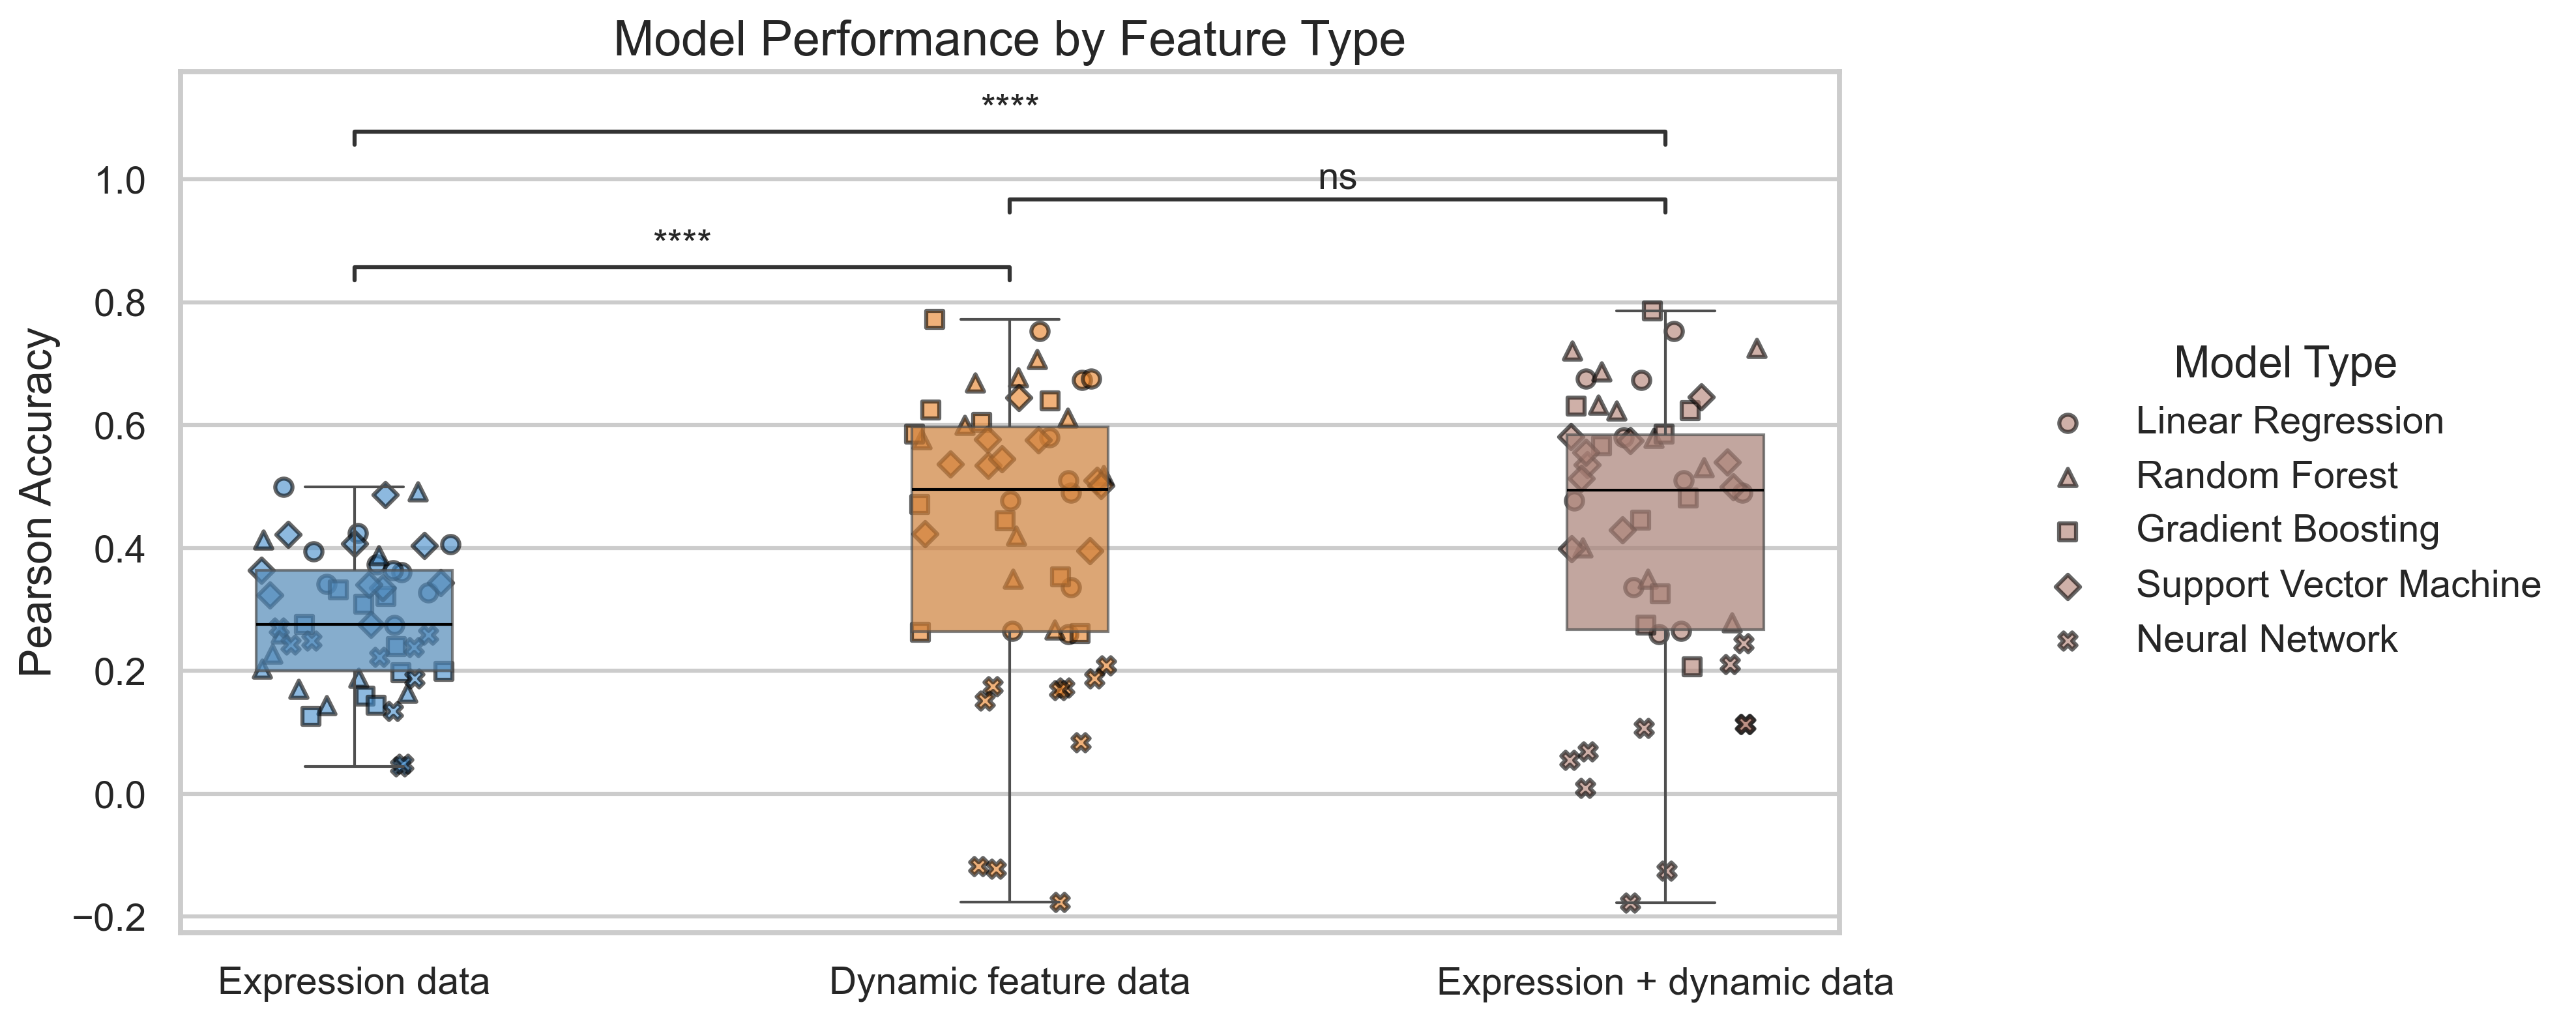

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import numpy as np
from statannotations.Annotator import Annotator
from matplotlib.gridspec import GridSpec

# Set color and marker styles
color_map = {
    "Expression data": "#428bca",
    "Dynamic feature data": "#e67e22",
    "Expression + dynamic data": "#b07c6f",
}

model_markers = {
    "Linear Regression": "o",
    "Random Forest": "^",
    "Gradient Boosting": "s",
    "Support Vector Machine": "D",
    "Neural Network": "X",
}

# Clean and filter the data
plot_data = metric_df.copy()
plot_data
plot_data["Feature Data"] = plot_data["Feature Data"].replace(
    {
        "feature_data": "Expression data",
        "last_time_data": "Last time point data",
        "dynamic_data": "Dynamic feature data",
        "combined_lp_data": "Expression + last point",
        "combined_dyn_data": "Expression + dynamic data",
    }
)

plot_data = plot_data[plot_data["Feature Data"].isin(color_map.keys())]
feature_order = list(color_map.keys())

# Print group statistics
print("Group-wise Pearson Correlation (mean ± std):\n")
group_stats = plot_data.groupby("Feature Data")["Pearson Correlation"].agg(
    ["mean", "std"]
)
for feature_type in feature_order:
    if feature_type in group_stats.index:
        mean = group_stats.loc[feature_type, "mean"]
        std = group_stats.loc[feature_type, "std"]
        print(f"{feature_type:<25}: {mean:.3f} ± {std:.3f}")

# Set plot style
sns.set_context("talk", font_scale=1.8)
sns.set_style("whitegrid")
matplotlib.rcParams["font.family"] = "Arial"

# Create figure with grid layout
fig = plt.figure(figsize=(14, 6), dpi=300)
gs = GridSpec(1, 2, width_ratios=[5, 1])  # Main plot:legend = 5:1
ax = fig.add_subplot(gs[0])  # Main plot area
legend_ax = fig.add_subplot(gs[1])  # Empty subplot for legend
legend_ax.axis("off")  # Hide axes

# Boxplot
sns.boxplot(
    data=plot_data,
    x="Feature Data",
    y="Pearson Correlation",
    hue="Feature Data",
    palette=color_map,
    width=0.3,
    showcaps=True,
    boxprops={"alpha": 0.7},
    medianprops={"color": "black"},
    ax=ax,
)

# Remove internal boxplot legend
legend = ax.get_legend()
if legend:
    legend.remove()

# Add statistical annotations
pairs = [
    ("Expression data", "Dynamic feature data"),
    ("Expression data", "Expression + dynamic data"),
    ("Dynamic feature data", "Expression + dynamic data"),
]

annotator = Annotator(
    ax,
    pairs,
    data=plot_data,
    x="Feature Data",
    y="Pearson Correlation",
    order=feature_order,
)
annotator.configure(
    test="t-test_paired",
    text_format="star",
    verbose=1,
    fontsize=14,
    line_height=0.02,
    line_offset=0.01,
)
annotator.apply_and_annotate()

# Overlay model markers
x_positions = {cat: i for i, cat in enumerate(feature_order)}
scatter_handles = []

for model_name, marker in model_markers.items():
    model_subset = plot_data[plot_data["Model"] == model_name]
    handle = None
    for _, row in model_subset.iterrows():
        x = x_positions[row["Feature Data"]] + np.random.uniform(-0.15, 0.15)
        y = row["Pearson Correlation"]
        sc = ax.scatter(
            x,
            y,
            color=color_map[row["Feature Data"]],
            marker=marker,
            s=40,
            edgecolor="black",
            alpha=0.6,
        )
        handle = sc  # Store the last scatter plot (for legend)
    if handle:
        scatter_handles.append((model_name, handle))

# Draw external legend
legend_ax.legend(
    [h for (_, h) in scatter_handles],
    [name for (name, _) in scatter_handles],
    title="Model Type",
    loc="center left",
    frameon=False,
    fontsize=14,
    title_fontsize=16,
)

# Axis and title styling
ax.set_title("Model Performance by Feature Type", fontsize=18)
ax.set_xlabel("")
ax.set_ylabel("Pearson Accuracy", fontsize=16)
ax.set_xticks(range(len(feature_order)))
ax.set_xticklabels(feature_order, rotation=0, fontsize=14)
ax.tick_params(axis="y", labelsize=14)
plt.tight_layout()

# Save and show
save_figure(notebook_config, plt.gcf(), 'model_performance_comparison_style_2', verbose=1)
plt.show()
